In [21]:
import os
from torchvision.transforms import Resize
import numpy as np
from PIL import Image, ImageDraw
import torch
import pandas as pd

1.0000000000000002


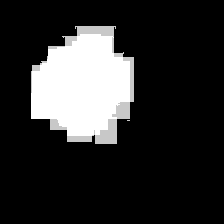

In [65]:
def createBBox(base_path):
    input_size = 224

    total_bbox=np.zeros((input_size, input_size))

    Bbox_path = base_path+'Bbox.npy'
    for path1 in ['train/', 'test/','validation/']:
        for path2 in ['0/', '1/']:
            images_path = base_path+path1+path2
            for file_name in os.listdir(images_path):
                img = Image.open(images_path+file_name)

                # 이미지 resize (224, 224)
                img = img.resize((input_size, input_size))
                
                # bouding box 안 1, 밖 0으로 설정
                img_np = np.array(img)
                img_np = np.where(img_np > 0, 1, 0)

                # 전체 bounding box 합침
                try:
                    total_bbox += img_np
                except:
                    img_np = img_np[:, :,0]
                    total_bbox += img_np
    
    original_heatmap = total_bbox
    
    # boudning box밖은 0이 아닌 최솟값으로 진행
    min_value = min(total_bbox[total_bbox != 0])
    np.where(total_bbox==0, min_value, total_bbox) 

    # 확률 분포로 변환
    total_bbox = total_bbox / np.sum(total_bbox)
    print(total_bbox.sum())
    #assert total_bbox.sum() == 1.0, f"{total_bbox.sum()}은 확률 분포가 아닙니다"

    # 저장    
    np.save(Bbox_path, total_bbox)
    totalBbox_img = Image.fromarray(original_heatmap*200).convert('RGB')
    totalBbox_img= totalBbox_img.convert('RGB')
    totalBbox_img.save(base_path+'Bbox.png')
    
    return totalBbox_img

base_path = 'C:/Users/janet/MyProjects/XAI_OP/data/DB_BBox/'
totalBbox_img = createBBox(base_path)
totalBbox_img

In [18]:
def patchify_heatmap(heatmaps, patch_size):
    """
    heatmaps batch를 받아서 (torch.Size([8, 224, 224]))
    [8, 224,224] 확률 분포 heatmap -> patch로 나눠서 [8, 14, 14, 16, 16] 
    patch 안의 값들은 sum -> [8, 14*14(196)]
    batch별로 각 값들은 확률분포를 따름
    """
    batch_size = heatmaps.shape[0]

    heatmaps = heatmaps.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    heatmaps = heatmaps.contiguous().view(batch_size, -1, patch_size*patch_size).sum(-1)
    return heatmaps

0.9999999999999999


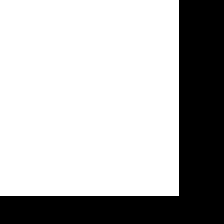

In [67]:
def createBBoxline(base_path, size=1):
    Bbox = np.load(base_path+'Bbox.npy')  
    Bbox_line = np.where(Bbox> 0, 1, 0)

    BoxPixels = np.where(Bbox_line==1)
    # 좌우 102,  상하 117
    # 1.5배 : 153, 상하 175.5
    left = min(BoxPixels[1]) # 31
    right = max(BoxPixels[1]) # 133
    bottom = min(BoxPixels[0]) # 26
    top = max(BoxPixels[0]) # 143

    center_x = (left + right) / 2
    center_y = (top + bottom) / 2

    width = right - left
    height = top - bottom

    new_width = width * size
    new_height = height * size

    new_left = max(0, int(center_x - new_width / 2))
    new_right = min(Bbox_line.shape[1], int(center_x + new_width / 2))
    new_top = max(0, int(center_y - new_height / 2))
    new_bottom = min(Bbox_line.shape[0], int(center_y + new_height / 2))
    
    Bbox_line[new_top:new_bottom+1, new_left:new_right+1] = 1

    # 확률 분포로 변환
    Bbox_line = Bbox_line / np.sum(Bbox_line)
    print(Bbox_line.sum())
    #assert Bbox_line.sum()==1.0, f"{Bbox_line.sum()}은 확률분포가 아닙니다"

    Bbox_line_img = Image.fromarray(np.where(Bbox_line>0, 255, 0)).convert('RGB')

    np.save(base_path+f'BboxLine_{size}.npy', Bbox_line)
    Bbox_line_img.save(base_path+f'BboxLine_{size}.jpg')

    return Bbox_line_img

base_path = 'C:/Users/janet/MyProjects/XAI_OP/data/DB_BBox/'
size = 1.9
Bbox_line_img = createBBoxline(base_path, size)
Bbox_line_img

In [50]:
# 90% -> 196개 중 19개 남김/ 177개 지움
# 75% -> 196개 중 49개 남김 / 147개 지움

# heatmap : 53개
# 기본 Line : 64개
# Line 1.5배 : 110개
# Line 1.8배 : 132개
# Line 1.9배 : 156개 -> CNN
# 2, 2.1 : 156
# 2.2 : 182 -> vit

heatmap = np.load(f'../../data/DB_BBox/BboxLine_{size}.npy')
heatmap = torch.from_numpy(heatmap)
heatmaps = heatmap.unsqueeze(0).repeat(8,1,1)
heatmaps = patchify_heatmap(heatmaps, 16)
h = pd.DataFrame(heatmaps[0, :]) 
h.value_counts()

0  
256    156
0       14
48      13
96      12
18       1
Name: count, dtype: int64